# Logistic Regression Neural Network From Scratch

In [224]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Steps:
1. develop utility functions:
    - relu activation
    - sigmoid activation
    - relu gradient
    - sigmoid gradient
2. initialize parameters
3. linear_forward
    - cache values
4. compute cost
5. linear_backward
6. update parameters
7. classify
8. display graphs

In [225]:
# utility functions:

def relu_function(Z):
    return np.maximum(Z, 0)

def sigmoid_function(Z):
    return 1/(1 + np.exp(-Z))

def relu_gradient(Z):
    return np.where(Z > 0, 1, 0)

def sigmoid_gradient(Z):
    return sigmoid_function(Z) * (1 - sigmoid_function(Z))

X shape: (2, 400)
Y shape: (1, 400)


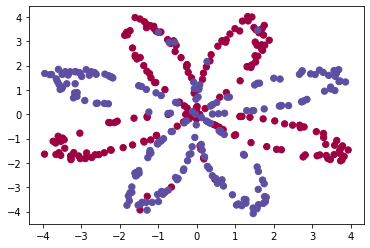

In [226]:
def load_planar_dataset():
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

X, Y = load_planar_dataset()
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral)
print('X shape:', X.shape)
print('Y shape:', Y.shape)

In [227]:
def initialize_parameters(X, hidden_layers):    
    W = {}
    b = {}
    nodes_prev_layer = X.shape[0] # get number of nodes from input layer
    layers = hidden_layers + [1] # the final layer in logestic regression will be a single logistic unit
    
    for layer, nodes in enumerate(layers):
        W[layer+1] = np.random.randn(nodes, nodes_prev_layer) * 0.01 # n.b. we have to scale down W with constant `0.01`
        b[layer+1] = np.zeros((nodes, 1))
        
        nodes_prev_layer = nodes

    return W, b, layers

In [228]:
# Note: both `linear_forward` and `linear_activation_forward` are not called directly, but through `forward_propogation`
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    assert Z.shape[0] == W.shape[0]
    assert Z.shape[1] == A_prev.shape[1]
    return Z
    
def linear_activation_forward(A_prev, W, b, activation='relu'):
    Z = linear_forward(A_prev, W, b)
    
    if activation == 'relu':
        A = relu_function(Z)
    elif activation == 'sigmoid':
        A = sigmoid_function(Z)
    else:
        raise ValueError('Invalid activation function: %s' % activation)
        
    assert A.shape == Z.shape
    
    return A, Z

In [229]:
def forward_propogation(X, layers, A, Z, W, b):
    # TODO: you're using `layers` as param, but also have `hidden_layers` in other methods;
    # this is confusing and can lead to bugs when refactoring; need to ensure consistency and prevent bugs.
    
    # TODO: `A` and `Z` should be an empty dict when it's first called; thus, as a class, they should not be passed as a params (?)
    
    # TODO: method parameters `A` `dZ` `dW` etc. are sometimes arrays and sometimes dicts; 
    # need to rename them to clarify which ones are dicts and which are arrs
    
    # the 'activated' unit for layer 0 is just the input:
    A[0] = X
    
    # propogate and compute activations for hidden layers
    L = len(layers)
    for l in range(1, L+1):
        if l < L:
            activation = 'relu'
        # use last layer for logistic activation:
        else:
            activation = 'sigmoid'
        
        A[l], Z[l] = linear_activation_forward(A[l-1], W[l], b[l], activation)
        
    return A, Z

In [230]:
##############################
# TODO: Delete me
##############################
def L_model_forward_test_case_2hidden():
    np.random.seed(6)
    X = np.random.randn(5,4)
    W1 = np.random.randn(4,5)
    b1 = np.random.randn(4,1)
    W2 = np.random.randn(3,4)
    b2 = np.random.randn(3,1)
    W3 = np.random.randn(1,3)
    b3 = np.random.randn(1,1)
  
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    W = {
        1: W1,
        2: W2,
        3: W3
    }
    
    b = {
        1: b1,
        2: b2,
        3: b3
    }
    
    return X, W, b

X, W, b = L_model_forward_test_case_2hidden()
layers = [4, 3, 1]
A, Z = forward_propogation(X, layers, A, Z, W, b)
print('A:')
print(A)

A:
{1: array([[0.        , 3.18040136, 0.4074501 , 0.        ],
       [0.        , 0.        , 3.18141623, 0.        ],
       [4.18500916, 0.        , 0.        , 2.72141638],
       [5.05850802, 0.        , 0.        , 3.82321852]]), 2: array([[ 2.2644603 ,  1.09971298,  0.        ,  1.54036335],
       [ 6.33722569,  0.        ,  0.        ,  4.48582383],
       [10.37508342,  0.        ,  1.63635185,  8.17870169]]), 3: array([[0.03921668, 0.70498921, 0.19734387, 0.04728177]]), 0: array([[-0.31178367,  0.72900392,  0.21782079, -0.8990918 ],
       [-2.48678065,  0.91325152,  1.12706373, -1.51409323],
       [ 1.63929108, -0.4298936 ,  2.63128056,  0.60182225],
       [-0.33588161,  1.23773784,  0.11112817,  0.12915125],
       [ 0.07612761, -0.15512816,  0.63422534,  0.810655  ]])}


In [241]:
def compute_cost(Y_hat, Y):
    m = Y.shape[1] # m = number of training examples

    cost = -1/m * np.sum( (Y*np.log(Y_hat)) + ((1-Y) * np.log(1-Y_hat)) )
    cost = np.squeeze(cost)
    
    assert(cost.shape == ())
    
    return cost

In [232]:
def linear_backward(A_prev, dA, W, Z, b, activation='relu'):
    m = A_prev.shape[1]
    
    if activation == 'relu':
        dZ = dA * relu_gradient(Z)
    elif activation == 'sigmoid':
        dZ = dA * sigmoid_gradient(Z)
    
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ) # dA for the previous layer (dA[l-1])
    
    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape
    
    return dA_prev, dZ, dW, db

In [233]:
def backward_propogation(Y, A, Z, W, b, dA, dZ, dW, db, layers):
    L = len(layers)
    
    for l in reversed(range(1, L+1)):
        if l == L:
            dA[l] = -(np.divide(Y, A[l]) - (np.divide(1-Y, 1-A[l])))
            activation = 'sigmoid'
        else:
            activation = 'relu'
        dA[l-1], dZ[l], dW[l], db[l] = linear_backward(A[l-1], dA[l], W[l], Z[l], b[l], activation)
        
    return dA, dZ, dW, db

# def backprop_2(AL, Y, layers):
#     L = 

In [234]:
########################################################
# TODO: DELETE ME
########################################################
def L_model_backward_test_case():
    """
    X = np.random.rand(3,2)
    Y = np.array([[1, 1]])
    parameters = {'W1': np.array([[ 1.78862847,  0.43650985,  0.09649747]]), 'b1': np.array([[ 0.]])}

    aL, caches = (np.array([[ 0.60298372,  0.87182628]]), [((np.array([[ 0.20445225,  0.87811744],
           [ 0.02738759,  0.67046751],
           [ 0.4173048 ,  0.55868983]]),
    np.array([[ 1.78862847,  0.43650985,  0.09649747]]),
    np.array([[ 0.]])),
   np.array([[ 0.41791293,  1.91720367]]))])
   """
    np.random.seed(3)
    AL = np.random.randn(1, 2)
    Y = np.array([[1, 0]])

    A1 = np.random.randn(4,2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    Z1 = np.random.randn(3,2)
    linear_cache_activation_1 = ((A1, W1, b1), Z1)

    A2 = np.random.randn(3,2)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    Z2 = np.random.randn(1,2)
    linear_cache_activation_2 = ((A2, W2, b2), Z2)

    caches = (linear_cache_activation_1, linear_cache_activation_2)
    A = {
        1: A1,
        2: A2
    }
    
    W = {
        1: W1,
        2: W2
    }
    
    b = {
        1: b1,
        2: b2
    }
    
    Z = {
        1: Z1,
        2: Z2
    }

    return AL, Y, A, Z, W, b

####
layers = [3, 1, 1]
AL, Y, A, Z, W, b = L_model_backward_test_case()
A[3] = AL
dA, dZ, dW, db = backward_propogation(Y, A, Z, W, b, dA, dZ, dW, db, layers)


KeyError: 3

In [235]:
########################################################
# TODO: DELETE ME
########################################################
def linear_activation_backward_test_case():
    """
    aL, linear_activation_cache = (np.array([[ 3.1980455 ,  7.85763489]]), ((np.array([[-1.02387576,  1.12397796], [-1.62328545,  0.64667545], [-1.74314104, -0.59664964]]), np.array([[ 0.74505627,  1.97611078, -1.24412333]]), 5), np.array([[ 3.1980455 ,  7.85763489]])))
    """
    np.random.seed(2)
    dA = np.random.randn(1,2)
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    Z = np.random.randn(1,2)
    linear_cache = (A, W, b)
    activation_cache = Z
    linear_activation_cache = (linear_cache, activation_cache)

    
    return dA, A, W, b, Z

dA, A_prev, W, b, Z = linear_activation_backward_test_case()
_activation = 'sigmoid'
dA_prev, dZ, dW, db = linear_backward(A_prev, dA, W, Z, b, _activation)
print ("--- %s: ---" % _activation)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")


--- sigmoid: ---
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]



In [236]:
def update_parameters(W, dW, b, db, layers, learning_rate=1.2):
    L = len(layers)
    
    for l in range(1, L+1):
        W[l] = W[l] - (learning_rate * dW[l])
        b[l] = b[l] - (learning_rate * db[l])
    return W, b

In [242]:
def train_logestic_regression_model(X, Y, hidden_layers, num_iterations, learning_rate=1.2, print_cost=True):
    
    # initalize parameters:
    A = {}
    Z = {}
    dA = {}
    db = {}
    dW = {}
    dZ = {}
    gradients = {}
    
    W, b, layers = initialize_parameters(X, hidden_layers)
    m = Y.shape[1] # number of examples
    L = len(layers)
    
    for i in range(num_iterations):
        A, Z = forward_propogation(X, layers, A, Z, W, b)
        
        if print_cost and i % 1000 == 0:
            cost = compute_cost(A[L], Y)
            print('cost at %s iterations: %s' % (i, cost))
        
        dA, dZ, dW, db = backward_propogation(Y, A, Z, W, b, dA, dZ, dW, db, layers)
        W, b = update_parameters(W, dW, b, db, layers, learning_rate)

In [243]:
hidden_layers = [4]
train_logestic_regression_model(X, Y, hidden_layers, 10000, learning_rate=1.2)

ValueError: operands could not be broadcast together with shapes (1,2) (1,4) 